In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import keras

sys.path.append("..")
import second_dream

Using TensorFlow backend.


In [3]:
dataset_name = "GunPoint"
model_name = "ResNet"

In [4]:
testset = np.loadtxt(os.path.join("auxiliary", "testsets", f"{dataset_name}_TEST.tsv"), delimiter="\t")
X = testset[:, 1:]
y = testset[:, 0].astype(int)
unique_labels = np.unique(y)

In [5]:
model = keras.models.load_model(os.path.join("auxiliary", "models", model_name, f"{dataset_name}.hdf5"))
instrument = second_dream.instrument_model(model)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [6]:
print("Available layers:")
print(", ".join(l.name for l in model.layers))

Available layers:
input_1, conv1d_1, batch_normalization_1, activation_1, conv1d_2, batch_normalization_2, activation_2, conv1d_4, conv1d_3, batch_normalization_4, batch_normalization_3, add_1, activation_3, conv1d_5, batch_normalization_5, activation_4, conv1d_6, batch_normalization_6, activation_5, conv1d_8, conv1d_7, batch_normalization_8, batch_normalization_7, add_2, activation_6, conv1d_9, batch_normalization_9, activation_7, conv1d_10, batch_normalization_10, activation_8, conv1d_11, batch_normalization_12, batch_normalization_11, add_3, activation_9, global_average_pooling1d_1, dense_1


In [7]:
def demo(loss_layers, hyperparams, base_timeser_idx=None, base_timeser=None):
    def predict(u_timeser):
        return dict(zip(range(len(unique_labels)), model.predict(np.reshape(u_timeser, (1, -1, 1)))[0]))

    print("Hyperparams:", {**second_dream.DEFAULT_HYPERPARAMS, **hyperparams})

    if base_timeser is not None:
        base_u_timeser = base_timeser
    else:
        base_u_timeser = X[base_timeser_idx, :]
        print("True class:", np.argwhere(unique_labels == y[base_timeser_idx])[0, 0])

    print("Base prediction: ", predict(base_u_timeser))

    dream_u_timeser = second_dream.dream(model, loss_layers, base_u_timeser, fetch_loss_and_grads=instrument, verbose=False, **hyperparams)

    print("Dream prediction:", predict(dream_u_timeser))

    plt.figure(figsize=(10, 4))
    plt.plot(base_u_timeser, label="Base")
    plt.plot(dream_u_timeser, label="Dream")
    plt.legend()

# Example 1: Maximize activation of whole last layer

Hyperparams: {'step': 0.01, 'num_octave': 1, 'octave_scale': 1.4, 'iterations': 30, 'max_loss': 10.0}
True class: 1
Base prediction:  {0: 0.60339814, 1: 0.3966019}
Dream prediction: {0: 1.0, 1: 6.397822e-10}


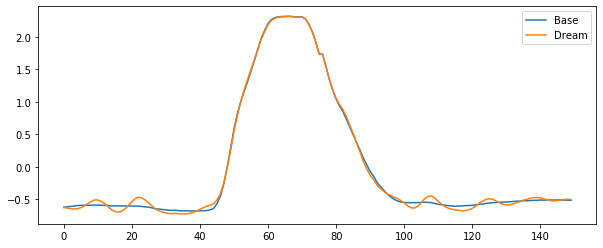

In [8]:
base_timeser_idx = 12

loss_layers = {
    "dense_1": 1.0
}

hyperparams = {
    "num_octave": 1,
    "iterations": 30
}

demo(loss_layers, hyperparams, base_timeser_idx)

# Example 2: Maximize activation of true class

Hyperparams: {'step': 0.01, 'num_octave': 1, 'octave_scale': 1.4, 'iterations': 30, 'max_loss': 10.0}
True class: 1
Base prediction:  {0: 0.60339814, 1: 0.3966019}
Dream prediction: {0: 1.7739278e-05, 1: 0.99998224}


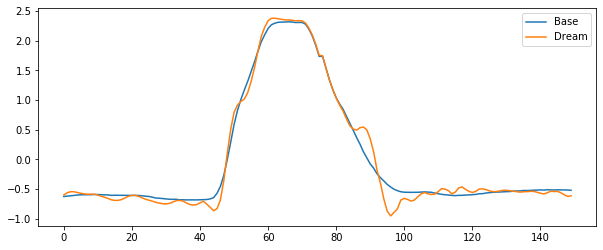

In [9]:
base_timeser_idx = 12

loss_layers = {
    "dense_1": {1: 1.0}
}

hyperparams = {
    "num_octave": 1,
    "iterations": 30
}

demo(loss_layers, hyperparams, base_timeser_idx)

# Example 3: Maximize activation of true class using more iterations

Hyperparams: {'step': 0.01, 'num_octave': 1, 'octave_scale': 1.4, 'iterations': 200, 'max_loss': 10.0}
True class: 1
Base prediction:  {0: 0.60339814, 1: 0.3966019}
Dream prediction: {0: 1.141661e-08, 1: 1.0}


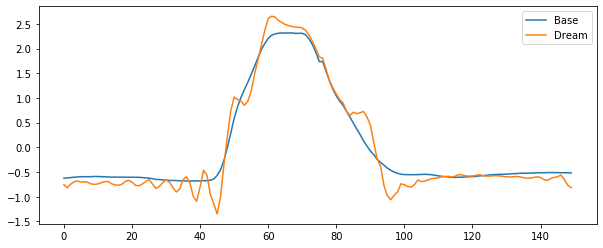

In [10]:
base_timeser_idx = 12

loss_layers = {
    "dense_1": {1: 1.0}
}

hyperparams = {
    "num_octave": 1,
    "iterations": 200
}

demo(loss_layers, hyperparams, base_timeser_idx)

# Example 4: Maximize activation of hidden layers

Hyperparams: {'step': 0.01, 'num_octave': 1, 'octave_scale': 1.4, 'iterations': 20, 'max_loss': 10.0}
True class: 0
Base prediction:  {0: 0.99992216, 1: 7.779941e-05}
Dream prediction: {0: 1.1957783e-06, 1: 0.9999988}


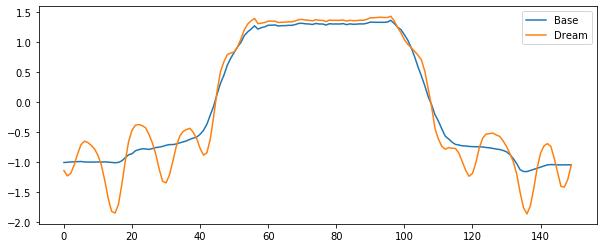

In [11]:
base_timeser_idx = 3

loss_layers = {
    "activation_2": 1.0,
    "add_2": 0.5
}

hyperparams = {
    "num_octave": 1,
    "iterations": 20
}

demo(loss_layers, hyperparams, base_timeser_idx)

# Example 5: Maximize activation of hidden layers using more than one octave

Hyperparams: {'step': 0.01, 'num_octave': 5, 'octave_scale': 1.4, 'iterations': 20, 'max_loss': 10.0}
True class: 0
Base prediction:  {0: 0.99992216, 1: 7.779941e-05}
Dream prediction: {0: 1.3396014e-18, 1: 1.0}


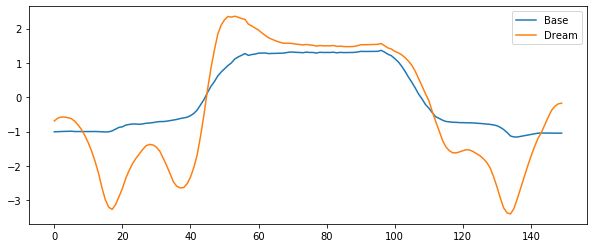

In [12]:
base_timeser_idx = 3

loss_layers = {
    "activation_2": 1.0,
    "add_2": 0.5
}

hyperparams = {
    "num_octave": 5,
    "iterations": 20
}

demo(loss_layers, hyperparams, base_timeser_idx)

# Example 6: Start with a zero time series and maximize class 0

Hyperparams: {'step': 0.01, 'num_octave': 1, 'octave_scale': 1.4, 'iterations': 100, 'max_loss': 10.0}
Base prediction:  {0: 0.987743, 1: 0.012257032}
Dream prediction: {0: 1.0, 1: 2.378195e-09}


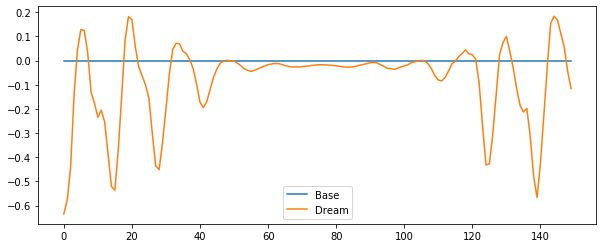

In [13]:
base_timeser = np.zeros(X.shape[1])

loss_layers = {
    "dense_1": {0: 1.0}
}

hyperparams = {
    "num_octave": 1,
    "iterations": 100
}

demo(loss_layers, hyperparams, base_timeser=base_timeser)

# Example 7: Start with a zero time series and maximize class 1

Hyperparams: {'step': 0.05, 'num_octave': 1, 'octave_scale': 1.4, 'iterations': 100, 'max_loss': 10.0}
Base prediction:  {0: 0.987743, 1: 0.012257032}
Dream prediction: {0: 2.564883e-09, 1: 1.0}


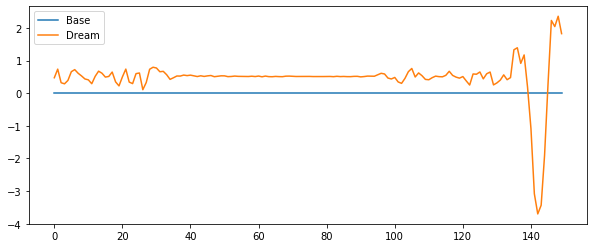

In [14]:
base_timeser = np.zeros(X.shape[1])

loss_layers = {
    "dense_1": {1: 1.0}
}

hyperparams = {
    "step": 0.05,
    "num_octave": 1,
    "iterations": 100
}

demo(loss_layers, hyperparams, base_timeser=base_timeser)